In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

# Introduction to TorchGeo

_Written by: Adam J. Stewart_

Now that we've seen the basics of PyTorch and the challenges of working with geospatial data, let's see how TorchGeo addresses these challenges.

## Setup

First, we install TorchGeo and all of its dependencies.

In [2]:
%pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.8/850.8 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 44.4 MB/s eta 0:0

## Imports

Next, we import TorchGeo and any other libraries we need.

In [25]:
import os
import tempfile
from datetime import datetime

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from torchgeo.datasets import CDL, BoundingBox, Landsat7, Landsat8, stack_samples
from torchgeo.datasets.utils import download_and_extract_archive
from torchgeo.samplers import GridGeoSampler, RandomGeoSampler

## Motivation

Let's start with a common task in geospatial machine learning to motivate us: land cover mapping. Imagine you have a collection of imagery and a land cover layer or *mask* you would like to learn to predict. In machine learning, this pixelwise classification process is referred to as *semantic segmentation*.

More concretely, imagine you would like to combine a set of Landsat 7 and 8 scenes with the Cropland Data Layer (CDL). This presents a number of challenges for a typical machine learning pipeline:

* We may have hundreds of partially overlapping Landsat images that need to be mosaiced together
* We have a single CDL mask covering the entire continental US
* Neither the Landsat input or CDL output will have the same geospatial bounds
* Landsat is multispectral, and may have a different resolution for each spectral band
* Landsat 7 and 8 have a different number of spectral bands
* Landsat and CDL may have a differerent CRS
* Every single Landsat file may be in a different CRS (e.g., multiple UTM zones)
* We may have multiple years of input and output data, and need to ensure matching time spans

We can't have a dataset of length 1, and it isn't obvious what to do when the number, bounds, and size of input images differ from the output masks. Furthermore, each image is far too large to pass to a neural network.

Traditionally, people either performed classification on a single pixel at a time or curated their own benchmark dataset. This works fine for training, but isn't really useful for inference. What we would really like to be able to do is sample small pixel-aligned pairs of input images and output masks from the region of overlap between both datasets. This exact situation is illustrated in the following figure:

![Landsat CDL intersection](https://github.com/microsoft/torchgeo/blob/main/images/geodataset.png?raw=true)

Now, let's see what features TorchGeo has to support this kind of use case.

## Datasets

Geospatial data comes in a wide variety of formats. TorchGeo has two separate classes of datasets to deal with this dataset diversity:

* `NonGeoDataset`: for curated benchmark datasets, where geospatial metadata is either missing or unnecessary
* `GeoDataset`: for uncurated raster and vector data layers, where geospatial metadata is critical for merging datasets

We have already seen the former in the Introduction to PyTorch tutorial, as `EuroSAT100` is a subclass of `NonGeoDataset`. In this tutorial, we will focus on the latter and its advantages for working with uncurated data.

### Landsat

First, let's start with our Landsat imagery. We will download a couple of Landsat 7 and 8 scenes, then pass them to builtin TorchGeo datasets for each.

In [47]:
landsat_root = os.path.join(tempfile.gettempdir(), 'landsat')

url = 'https://hf.co/datasets/torchgeo/tutorials/resolve/ff30b729e3cbf906148d69a4441cc68023898924/'
landsat7_url = url + 'LE07_L2SP_022032_20230725_20230820_02_T1.tar.gz'
landsat8_url = url + 'LC08_L2SP_023032_20230831_20230911_02_T1.tar.gz'

download_and_extract_archive(landsat7_url, landsat_root)
download_and_extract_archive(landsat8_url, landsat_root)

landsat7_bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
landsat8_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

landsat7 = Landsat7(paths=landsat_root, bands=landsat7_bands)
landsat8 = Landsat8(paths=landsat_root, bands=landsat8_bands)

print(landsat7)
print(landsat8)

print(landsat7.crs)
print(landsat8.crs)

Using downloaded and verified file: /tmp/landsat/LE07_L2SP_022032_20230725_20230820_02_T1.tar.gz
Extracting /tmp/landsat/LE07_L2SP_022032_20230725_20230820_02_T1.tar.gz to /tmp/landsat
Using downloaded and verified file: /tmp/landsat/LC08_L2SP_023032_20230831_20230911_02_T1.tar.gz
Extracting /tmp/landsat/LC08_L2SP_023032_20230831_20230911_02_T1.tar.gz to /tmp/landsat
Landsat7 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=919035.8962764405, maxx=951840.0990326208, miny=4456195.4346259395, maxy=4488999.63738212, mint=1690243200.0, maxt=1690329599.999999)
    size: 1
Landsat8 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=410000.0, maxx=440720.0, miny=4445000.0, maxy=4475720.0, mint=1693440000.0, maxt=1693526399.999999)
    size: 1
EPSG:32615
EPSG:32616


In [6]:
tempfile.gettempdir()

'/tmp'

The following details are worth noting:

* We ignore the "coastal blue" band of Landsat 8 because it does not exist in Landsat 7
* Even though all files are stored in the same directory, the datasets know which files to include
* `paths` can be a directory to recursively search, a list of local files, or even a list of remote cloud assets

### CDL

Next, let's do the same for the CDL dataset. We are using a smaller cropped version of this dataset to make the download faster.

In [48]:
cdl_root = os.path.join(tempfile.gettempdir(), 'cdl')

cdl_url = url + '2023_30m_cdls.zip'

download_and_extract_archive(cdl_url, cdl_root)

cdl = CDL(paths=cdl_root)

print(cdl)
print(cdl.crs)

Using downloaded and verified file: /tmp/cdl/2023_30m_cdls.zip
Extracting /tmp/cdl/2023_30m_cdls.zip to /tmp/cdl
CDL Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=667000.0, maxx=697720.0, miny=1931000.0, maxy=1961720.0, mint=1672531200.0, maxt=1704067199.999999)
    size: 1
EPSG:5070


Again, the following details are worth noting:

* We could actually ask the `CDL` dataset to download our data for us by adding `download=True`
* All datasets have different spatial extents
* All datasets have different CRSs

### Composing datasets

We would like to be able to intelligently combine all three datasets in order to train a land cover mapping model. This requires us to create a virtual mosaic of all Landsat scenes, regardless of overlap. This can be done by taking the *union* of both datasets.

In [8]:
landsat = landsat7 | landsat8
print(landsat)
print(landsat.crs)

Converting Landsat8 CRS from EPSG:32616 to EPSG:32615
Converting Landsat8 res from 30.0 to 30.06801352537148
UnionDataset Dataset
    type: UnionDataset
    bbox: BoundingBox(minx=919035.8962764405, maxx=951841.012433807, miny=4456194.529344421, maxy=4488999.63738212, mint=1690243200.0, maxt=1693526399.999999)
    size: 2
EPSG:32615


Similarly, we only want to sample from locations with both input imagery and output masks, not locations with only one or the other. We can achieve this by taking the *intersection* of both datasets.

In [49]:
dataset = landsat & cdl
print(dataset)
print(dataset.crs)

Converting CDL CRS from EPSG:5070 to EPSG:32615
Converting CDL res from 30.0 to 30.06801352537148
IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=919035.8962764405, maxx=949998.3973081404, miny=4456194.529344421, maxy=4485913.465908965, mint=1690243200.0, maxt=1693526399.999999)
    size: 2
EPSG:32615


Note that all datasets now have the same CRS. When you run this code, you should notice it happen very quickly. TorchGeo hasn't actually created a mosaic yet or reprojected anything, it will do this on the fly for us.

### Spatiotemporal indexing

How did we do this? TorchGeo uses a data structure called an *R-tree* to store the spatiotemporal bounding box of every file in the dataset.

![R-tree](https://raw.githubusercontent.com/davidmoten/davidmoten.github.io/master/resources/rtree-3d/plot2.png)

TorchGeo extracts the spatial bounding box from the metadata of each file, and the timestamp from the filename. This geospatial and geotemporal metadata allows us to efficiently compute the intersection or union of two datasets. It also lets us quickly retrieve an image and corresponding mask for a particular location in space and time.

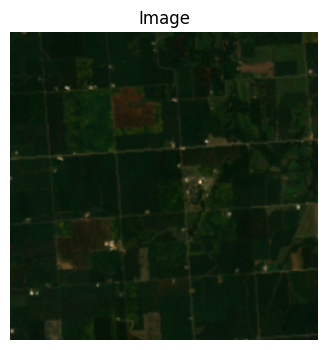

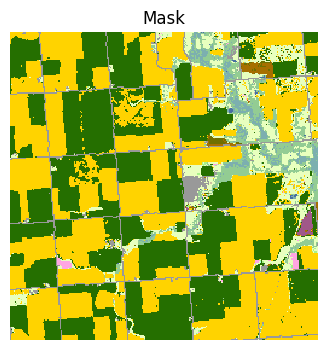

In [50]:
size = 256

xmin = 925000
xmax = xmin + size * 30
ymin = 4470000
ymax = ymin + size * 30
tmin = datetime(2023, 1, 1).timestamp()
tmax = datetime(2023, 12, 31).timestamp()

bbox = BoundingBox(xmin, xmax, ymin, ymax, tmin, tmax)
sample = dataset[bbox]

landsat8.plot(sample)
cdl.plot(sample)
plt.show()

TorchGeo uses *windowed-reading* to only read the blocks of memory needed to load a small patch from a large raster tile. It also automatically reprojects all data to the same CRS and resolution (from the first dataset). This can be controlled by explicitly passing `crs` or `res` to the dataset.

## Samplers

The above `BoundingBox` makes it easy to index into complex datasets consisting of hundreds of files. However, it is a bit cumbersome to manually construct these queries every time, especially if we want thousands or even millions of bounding boxes. Luckily, TorchGeo provides a `GeoSampler` class to construct these for us.

### Random sampling

Usually, at training time, we want the largest possible dataset we can muster. For curated benchmark datasets like `EuroSAT100`, we achieved this by applying data augmentation to artificially inflate the size and diversity of our dataset. For `GeoDataset` objects, we can achieve this using random sampling. It doesn't matter if two or more of our images have partial overlap, as long as they bring unique pixels that help our model learn.

TorchGeo provides a `RandomGeoSampler` to achieve this. We just tell the sampler how large we want each image patch to be (in pixel coordinates or CRS units) and, optionally, the number of image patches per epoch.

In [13]:
train_sampler = RandomGeoSampler(dataset, size=size, length=1000)
next(iter(train_sampler))

BoundingBox(minx=927515.0760905952, maxx=935212.4875530903, miny=4466417.653943047, maxy=4474115.065405542, mint=1693440000.0, maxt=1693526399.999999)

### Gridded sampling

At evaluation time, this actually becomes a problem. We want to make sure we aren't making multiple predictions for the same location. We also want to make sure we don't miss any locations. To achieve this, TorchGeo also provides a `GridGeoSampler`. We can tell the sampler the size of each image patch and the stride of our sliding window.

In [14]:
test_sampler = GridGeoSampler(dataset, size=size, stride=size)
next(iter(test_sampler))

BoundingBox(minx=919035.8962764405, maxx=926733.3077389356, miny=4456195.4346259395, maxy=4463892.846088435, mint=1690243200.0, maxt=1690329599.999999)

## Data Loaders

All of these abstractions (`GeoDataset` and `GeoSampler`) are fully compatible with all of the rest of PyTorch. We can simply pass them to a data loader like below. Note that we also need the `stack_samples` collation function to convert a list of samples to a mini-batch.

In [15]:
train_dataloader = DataLoader(
    dataset, batch_size=128, sampler=train_sampler, collate_fn=stack_samples
)
test_dataloader = DataLoader(
    dataset, batch_size=128, sampler=test_sampler, collate_fn=stack_samples
)

In [28]:
next(iter(train_dataloader))

{'crs': [CRS.from_wkt('PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32615"]]'),
  CRS.from_wkt('PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PAR

Now that we have working data loaders, we can copy-n-paste our training code from the Introduction to PyTorch tutorial. We only need to change our model to one designed for semantic segmentation, such as a U-Net. Every other line of code would be identical to how you would do this in your normal PyTorch workflow.

In [29]:
import os
import tempfile

import kornia.augmentation as K
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# from torchgeo.datasets import EuroSAT100
from torchgeo.models import ResNet18_Weights, resnet18

torch.manual_seed(0)

In [30]:
preprocess = K.Normalize(0, 10000)
augment = K.ImageSequential(K.RandomHorizontalFlip(), K.RandomVerticalFlip())

In [85]:
model = resnet18()

In [86]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [87]:
model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [88]:
loss_fn = nn.CrossEntropyLoss()

In [89]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [91]:
device

'cuda'

In [96]:
from torchvision import models

In [130]:
model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()

In [136]:
model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [139]:
train_maskrcnn(train_dataloader)

torch.Size([128, 1, 256, 256])
torch.Size([6, 256, 256])
torch.Size([1, 256, 256])


IndexError: too many indices for tensor of dimension 2

In [138]:
# def train(dataloader):
#     model.train()
#     total_loss = 0
#     for batch in dataloader:
#         inputs = batch['image'].to(device)  # Access the input images
#         targets = batch['mask'].to(device)  # Access the corresponding masks

#         # Forward pass
#         y_hat = model(inputs)
#         loss = loss_fn(y_hat, targets)
#         total_loss += loss.item()

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#     print(f'Loss: {total_loss:.2f}')

def train_maskrcnn(dataloader):
    # model.train()
    total_loss = 0
    for batch in dataloader:
        inputs = batch['image'].to(device)  # Access the input images
        targets = batch['mask'].to(device)  # Access the corresponding masks
        # plt.imshow(targets[1, 0, :, :].cpu())
        print(targets.shape)
        # loss_dict = model(inputs, targets[0:3, 0])
        # Put your training logic here

        for input, target in zip(inputs, targets):
            print(input.shape)
            print(target.shape)
            #optimizer.zero_grad()
            loss_dict = model(input[0:3], target)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses # .item()

            losses.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"{[img.shape for img in inputs] = }")
        print(f"{[type(target) for target in targets] = }")
        #for name, loss_val in loss_dict.items():
            #print(f"{name:<20}{loss_val:.3f}")


In [93]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'].to(device)
            y = batch['mask'].to(device)

            # Forward pass
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()

    correct /= len(dataloader.dataset)
    print(f'Accuracy: {correct:.0%}')

In [94]:
epochs = 100

In [95]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train(train_dataloader)
    evaluate(val_dataloader)

Epoch: 0


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

## Additional Reading

TorchGeo has plenty of other tutorials and documentation. If you would like to get more insight into the design of TorchGeo, the following external resources are also helpful:

* [TorchGeo: Deep Learning With Geospatial Data](https://arxiv.org/abs/2111.08872)
* [Geospatial deep learning with TorchGeo](https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/)